In [46]:
words = open('names.txt', 'r').read().splitlines()

In [47]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [48]:
len(words)

32033

In [49]:
min(len(w) for w in words)

2

In [50]:
max(len(w) for w in words)

15

In [51]:
b = {}
for w in words:
    # w is a string, list(w) is a list of char
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        # counts how often it occurs, defaulting to zero if not seen
        b[bigram] = b.get(bigram, 0) + 1
        # print(ch1, ch2)

In [52]:
# # reverse sort by count which is not zeroth element
# sorted(b.items(), key=lambda kv: -kv[1])

In [53]:
import torch

In [54]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [55]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}  # map letters to numbers
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [56]:
for w in words:
    # w is a string, list(w) is a list of char
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]  # getting index of letter
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1  # count up that letter pair

(-0.5, 26.5, 26.5, -0.5)

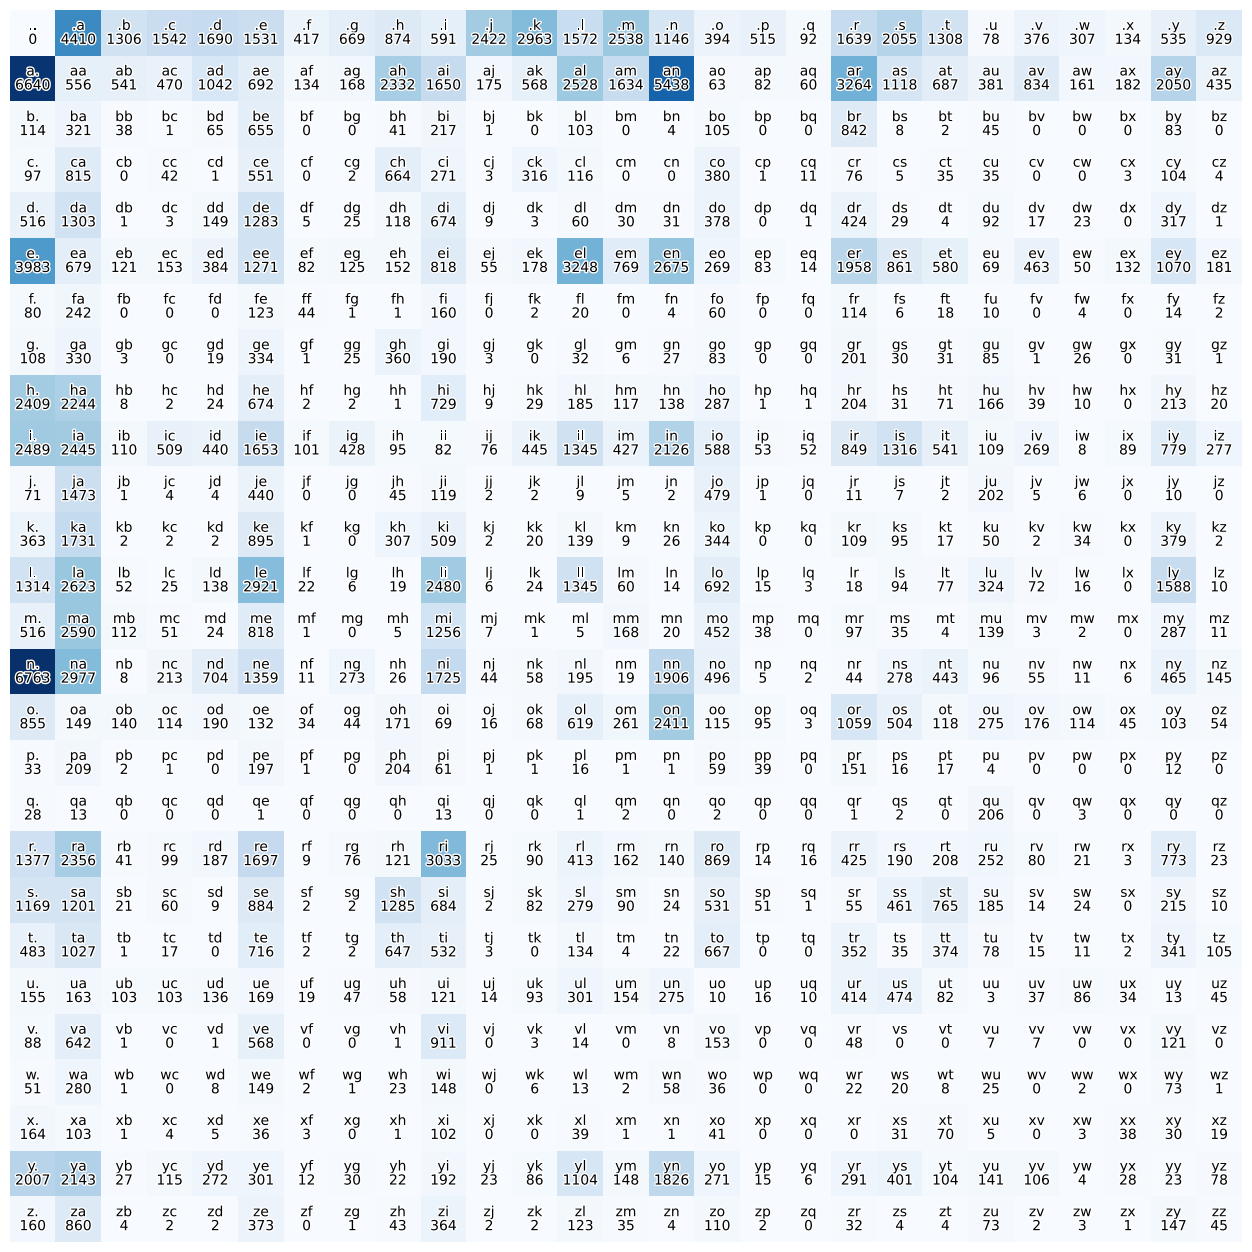

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='black',
                 path_effects=[pe.withStroke(linewidth=2, foreground="white")])
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='black',
                 path_effects=[pe.withStroke(linewidth=2, foreground="white")])
plt.axis('off')

In [139]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)
P[0].sum()
print(P[0].sum())

tensor(1.0000)


In [140]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        # p = N[ix].float()
        # p = p / p.sum()
        # p = torch.ones(27) / 27 # compare with "untrained".
        ix = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [60]:
# log(abc) = log(a) + log(b) + log(c)
# GOAL: Maximize  likelihood wrt parameters
# same as maximizing log-likelihood, or minimizing -LL or minimizing average -LL

In [61]:
log_likelihood = 0
n = 0
for w in ['andrejq']:  # words:
    # w is a string, list(w) is a list of char
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]  # getting index of letter
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1  # count up that letter pair
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(ch1, ch2, f'{prob:.4f}', f'{logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

. a 0.1376 -1.9835
a n 0.1604 -1.8302
n d 0.0384 -3.2594
d r 0.0770 -2.5646
r e 0.1334 -2.0143
e j 0.0027 -5.9004
j q 0.0003 -7.9817
q . 0.0970 -2.3331
log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
nll/n=tensor(3.4834)


In [62]:
# create training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [63]:
xs.dtype

torch.int64

torch.Size([5, 27])
torch.float32


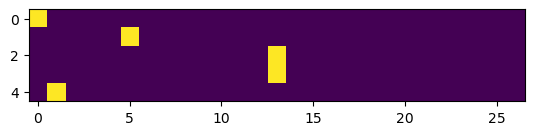

In [64]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)
plt.imshow(xenc)
print(xenc.dtype)

In [65]:
W = torch.randn((27, 27))
# 5,27 @ 27,27 = 5,27  (5 inputs, 27 chars, output is (5,27) gives for each of the 5 examples, what is the firing rate for each char?)
xenc @ W

tensor([[ 0.6269,  1.0765,  0.2026, -0.2424,  0.1882,  0.2666, -0.1896, -1.4372,
          1.0335,  0.4555,  0.0147,  1.4179,  0.5954,  1.2806, -0.7088, -1.6386,
          0.7443, -0.8863, -2.2661,  0.2973,  0.3864, -0.2918,  0.7763,  1.0843,
          0.0546,  0.0723, -0.3742],
        [-0.2197, -0.0611, -1.1989, -0.6346, -1.1744, -0.4297,  0.1642,  1.4669,
         -1.5268,  1.5988,  0.8496, -1.4964,  0.3645, -1.0233,  0.2168,  0.1321,
         -0.3847, -0.1530,  0.1543,  0.6475, -1.3687,  0.8674,  1.2420, -0.5114,
         -0.6110,  1.0581, -0.3438],
        [-0.7728,  1.8000,  0.7414,  0.8073, -1.8404,  0.4370,  0.3361,  0.4715,
          0.9314, -0.7595, -0.4447,  0.8405,  0.5539, -1.5832, -0.1845, -1.5529,
          0.1747,  0.1570, -0.4406, -0.2514,  0.5727, -1.9202, -1.2864,  0.8175,
          0.7033,  1.0248, -0.6329],
        [-0.7728,  1.8000,  0.7414,  0.8073, -1.8404,  0.4370,  0.3361,  0.4715,
          0.9314, -0.7595, -0.4447,  0.8405,  0.5539, -1.5832, -0.1845, -1.5529

In [66]:
print((xenc[3] * W[:, 13]).sum())  # dot product
print((xenc @ W)[3, 13])

tensor(-1.5832)
tensor(-1.5832)


In [67]:
logits = xenc @ W  # ~log counts
counts = logits.exp()  # equivalent to our earlier N
probs = counts / counts.sum(1, keepdim=True)
print(probs[0].sum(), probs.shape)

tensor(1.0000) torch.Size([5, 27])


In [68]:
probs[0]  # given the first example chat, how likely is any of the 27 chars to come next?

tensor([0.0466, 0.0731, 0.0305, 0.0195, 0.0301, 0.0325, 0.0206, 0.0059, 0.0700,
        0.0393, 0.0253, 0.1028, 0.0452, 0.0896, 0.0123, 0.0048, 0.0524, 0.0103,
        0.0026, 0.0335, 0.0366, 0.0186, 0.0541, 0.0736, 0.0263, 0.0268, 0.0171])

In [69]:
# SUMMARY ------------------------------------------------------------------>>>>>>>>>>

In [70]:
xs

tensor([ 0,  5, 13, 13,  1])

In [71]:
ys

tensor([ 5, 13, 13,  1,  0])

In [72]:
# randomly initialize
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [73]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()  # EXP makes everything positive
# NORMALIZING makes everything in [0,1]
probs = counts / counts.sum(1, keepdim=True)
# THIS IS THE SAME AS A SOFTMAX? Well, I guess e^logit / sum e^logits that's true

In [74]:
probs.shape

torch.Size([5, 27])

In [75]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()  # input char index
    # input char label (i.e. here the label is what is the right answer in the training set, here the next character haha)
    y = ys[i].item()
    print('-------------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} at indicies {x}, {y}')
    print('input is', x)
    print('output probs:', probs[i])
    p = probs[i, y]
    print('probability assigned by net to correct char:', p.item())
    logp = torch.log(p)
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=============================================')
print('avg nll, i.e. the loss =', nlls.mean().item())

-------------
bigram example 1: .e at indicies 0, 5
input is 0
output probs: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
probability assigned by net to correct char: 0.01228625513613224
negative log likelihood: 4.399273872375488
-------------
bigram example 2: em at indicies 5, 13
input is 5
output probs: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
probability assigned by net to correct char: 0.018050700426101685
negative log likelihood: 4.014570713043213
-------------
bigram example 3: mm at indicies 13, 13
input is 13
output probs: tensor([0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.

In [198]:
# putting it all together

# create training set of bigrams (x,y)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:', num)

# randomly initialize
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples: 228146


In [224]:
# gradient descent
for k in range(1000):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    # added in a regularization part that tends toward uniform distribution with W=0
    loss = -probs[torch.arange(num), ys].log().mean()  # + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    # zero_grad (we need to recompute from scratch every time weights change)
    W.grad = None
    loss.backward()

    # update
    W.data += -50 * W.grad

2.4562458992004395
2.4562418460845947
2.456238031387329
2.4562342166900635
2.456230401992798
2.456226110458374
2.4562227725982666
2.4562184810638428
2.456214666366577
2.4562108516693115
2.456207275390625
2.4562034606933594
2.4561996459960938
2.456195831298828
2.4561920166015625
2.456188440322876
2.4561846256256104
2.4561808109283447
2.456177234649658
2.4561734199523926
2.456169605255127
2.4561662673950195
2.456162452697754
2.4561588764190674
2.456155300140381
2.4561514854431152
2.4561479091644287
2.456144332885742
2.4561407566070557
2.45613694190979
2.4561336040496826
2.456129789352417
2.4561264514923096
2.456122875213623
2.4561192989349365
2.45611572265625
2.4561121463775635
2.456108808517456
2.4561052322387695
2.456101894378662
2.4560983180999756
2.456094741821289
2.4560914039611816
2.456087827682495
2.4560844898223877
2.4560813903808594
2.456077814102173
2.4560742378234863
2.456070899963379
2.4560675621032715
2.456064224243164
2.4560611248016357
2.456057548522949
2.456054210662842
2

In [195]:
(W**2).sum()

tensor(1884.3563, grad_fn=<SumBackward0>)

In [225]:
# How to sample from NN model

def sample(old=False):
    g = torch.Generator().manual_seed(2147483647)

    for i in range(5):
        out = []
        ix = 0
        while True:
            if old:
                p = P[ix]  # BEFORE
            else:
                # NOW
                xenc = F.one_hot(torch.tensor(
                    [ix]), num_classes=27).float()  # input
                logits = xenc @ W  # W is trained to predict log-counts
                counts = logits.exp()
                p = counts / counts.sum(1, keepdim=True)  # prob for next char
                if itos[ix] == 'p':
                    print(itos[ix], p)
            ix = torch.multinomial(
                p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if ix == 0:
                break
        print(''.join(out))


sample(old=True)
print('================')
sample(old=False)

junide.
janasah.
p.
cony.
a.
junide.
janasah.
p tensor([[0.0311, 0.2027, 0.0024, 0.0021, 0.0016, 0.1910, 0.0019, 0.0016, 0.1979,
         0.0584, 0.0019, 0.0018, 0.0143, 0.0019, 0.0007, 0.0565, 0.0370, 0.0007,
         0.1462, 0.0143, 0.0153, 0.0031, 0.0012, 0.0012, 0.0017, 0.0104, 0.0012]],
       grad_fn=<DivBackward0>)
p.
cony.
a.


In [214]:
stoi['j']

10

In [76]:
# randomly initialize
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [100]:
# This is actually the forward pass! Because we are applying the weights to the inputs and getting the output probabilities
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()  # EXP makes everything positive
# NORMALIZING makes everything in [0,1]
probs = counts / counts.sum(1, keepdim=True)
# THIS IS THE SAME AS A SOFTMAX? Well, I guess e^logit / sum e^logits that's true
# loss is nll
loss = -probs[torch.arange(5), ys].log().mean()  # better way to index into it

In [101]:
print(loss.item())

3.6692662239074707


In [98]:
# backward pass
W.grad = None  # sets gradients to "zero" in a more efficient way
loss.backward()  # fills in all the gradients all the way back

In [99]:
W.data += -0.1 * W.grad  # update step

In [79]:
# each elem of W.grad tells us the influence that weight has on the final loss
print(W.shape, W.grad.shape)

torch.Size([27, 27]) torch.Size([27, 27])


In [ ]:
# Calculate the loss. Evaluate the prob the NN gives the true labels
print(probs.shape)
print(ys)
# want probs[0,5], probs[1,13], ...
print([probs[i, ys[i]] for i in range(probs.shape[0])])

torch.Size([5, 27])
tensor([ 5, 13, 13,  1,  0])
[tensor(0.0123, grad_fn=<SelectBackward0>), tensor(0.0181, grad_fn=<SelectBackward0>), tensor(0.0267, grad_fn=<SelectBackward0>), tensor(0.0737, grad_fn=<SelectBackward0>), tensor(0.0150, grad_fn=<SelectBackward0>)]


In [81]:
loss = -probs[torch.arange(5), ys].log().mean()  # better way to index into it
print(loss)

tensor(3.7693, grad_fn=<NegBackward0>)
